# Comparing combined PCs vs task-specific PCs

I'm wondering if the task-specific PCs (at least the important ones) are contained within the PCs of the activations of the whole dataset.

If this is true, then it would be handy because we wouldn't need to have prior knowledge of what the separate tasks are in order to find them in the activation space (which is essentially true in all practical cases we care about).

In [12]:
import pandas as pd
import torch
from matplotlib import pyplot as plt
import numpy as np

In [2]:
df = pd.read_pickle("results/dfs/009-pca.pkl")
len(df)

100

In [47]:
def get_sims(pcsA, pcsB):
    """Get the similarity matrix between two sets of principal components."""
    return torch.matmul(pcsA.T, pcsB).numpy()


def compute_variances(pcs, acts, indices):
    return torch.stack(
        [torch.var((pcs[:, i] * acts[indices]).sum(-1)) for i in range(16)]
    )


def plot_similarity(
    sims, title="Dot-product Similarity of\nPrincipal Components", x_label=None
):
    fig, ax = plt.subplots(figsize=(6, 6))

    im = ax.imshow(sims, cmap="bwr", vmin=-1, vmax=1)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=14)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel("Combined Tasks", fontsize=14)


def plot_pca_variances(varA, varB, err_varA=None, err_varB=None):
    _, ax = plt.subplots(figsize=(6, 6))

    # plot the variances for task A
    ax.bar(range(len(varA)), varA, yerr=err_varA, label="Task A activations", alpha=0.5)
    ax.bar(range(len(varB)), varB, yerr=err_varB, label="Task B activations", alpha=0.5)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance")
    ax.set_title("Variance of Principal Components from Task A")
    ax.legend()

In [4]:
for i, row in df.sample(frac=1.0).iterrows():
    pcs, pcsA, pcsB = row["pcs"], row["pcsA"], row["pcsB"]
    break

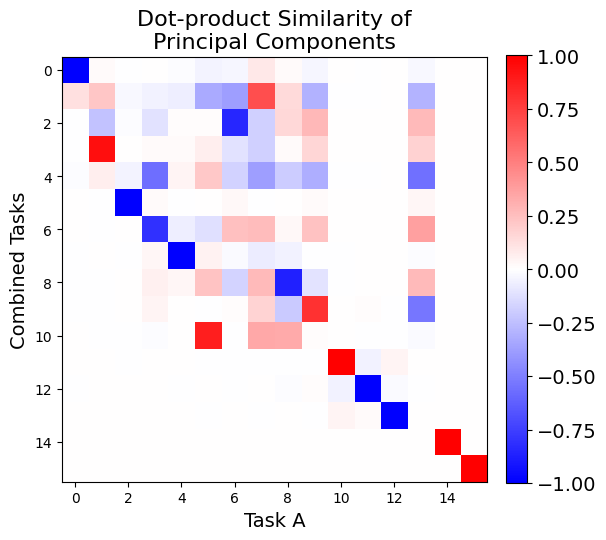

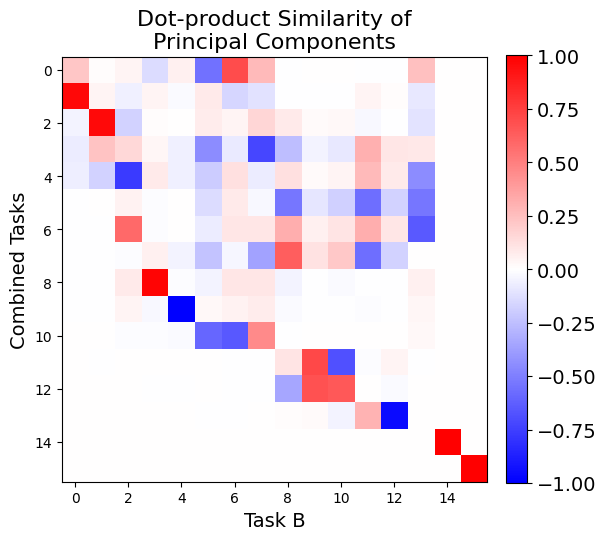

In [48]:
plot_similarity(get_sims(pcs, pcsA), x_label="Task A")
plot_similarity(get_sims(pcs, pcsB), x_label="Task B")

If we look in the region of interest (i.e. top-left) we can see that there are a handful of very aligned components and that they're not shared between the tasks, this is promising.

In [7]:
sliceA = slice(0, 10000)
sliceB = slice(10000, None)
varA = compute_variances(pcs, row["acts"], sliceA).numpy()
varB = compute_variances(pcs, row["acts"], sliceB).numpy()

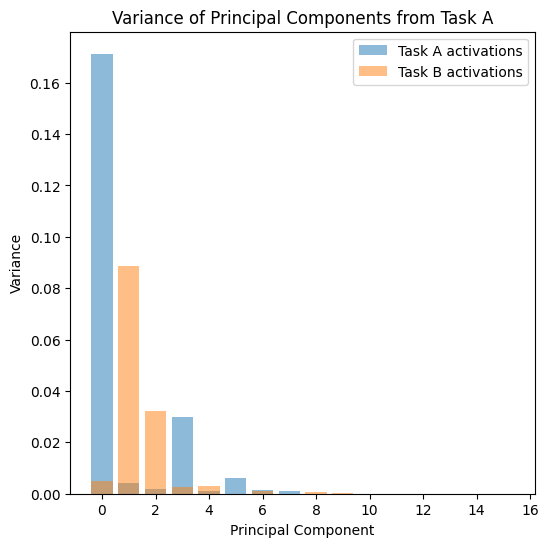

In [8]:
plot_pca_variances(varA, varB)

Nice, so PCA on all the activations grouped still picks out independent components more or less. I'd imagine this wouldn't be as clean in the wild though.

I'm sure the PCA is somewhat "confused" with the mixed distribution, creating some bleed in between the two tasks whereas _perhaps_ the next linear layer is better able to separate the tasks.

Some ideas on how to understand this distribution (across all the trained models):
- Plot the mean difference between the two task variances for each component (with some idea of uncertainty)
- I could just calculate a cosine distance for the normalised variances

In [35]:
varAs, varBs = [], []
for i, row in df.iterrows():
    varA = compute_variances(row["pcs"], row["acts"], sliceA).numpy()
    varB = compute_variances(row["pcs"], row["acts"], sliceB).numpy()
    varAs.append(varA)
    varBs.append(varB)

varAs = np.stack(varAs)
varBs = np.stack(varBs)

In [36]:
nvarAs = varAs / np.linalg.norm(varAs, axis=1)[:, None]
nvarBs = varBs / np.linalg.norm(varBs, axis=1)[:, None]

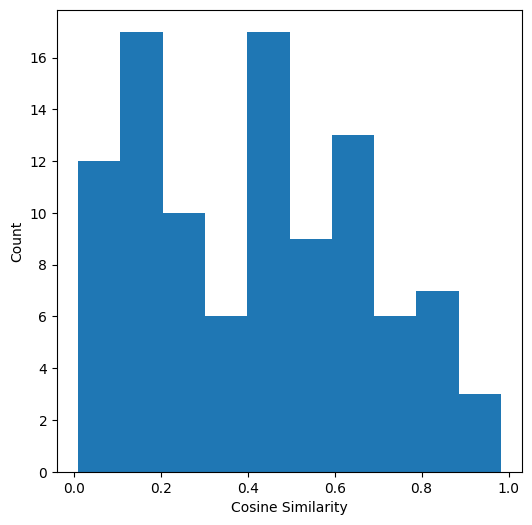

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist((nvarAs * nvarBs).sum(1))
ax.set_xlabel("Cosine Similarity")
_ = ax.set_ylabel("Count")

Hmm this doesn't look so good. I wonder if we need to focus more on the high-variance dimensions (but maybe that's done anyway?).

Now trying my other idea:

In [41]:
Δ = np.abs(varAs - varBs)
mean_Δ = Δ.mean(0)
err_Δ = Δ.std(0) / np.sqrt(len(Δ))
mean_Δ.shape, err_Δ.shape

((16,), (16,))

Text(0.5, 1.0, 'Variance separation between tasks across PCs')

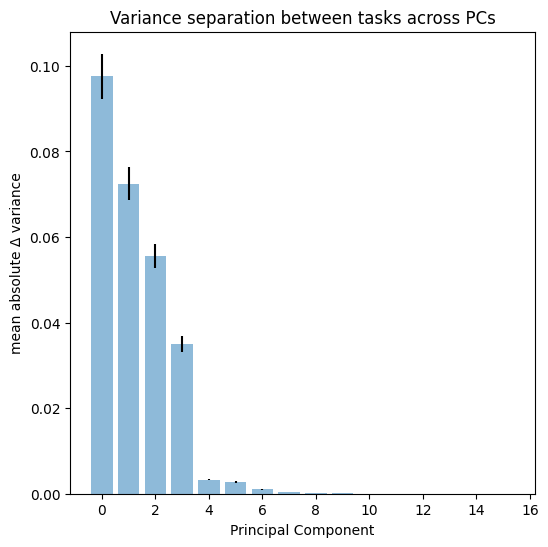

In [62]:
_, ax = plt.subplots(figsize=(6, 6))

# plot the variances for task A
ax.bar(range(len(mean_Δ)), mean_Δ, yerr=err_Δ, alpha=0.5)
ax.set_xlabel("Principal Component")
ax.set_ylabel("mean absolute Δ variance")
ax.set_title("Variance separation between tasks across PCs")

This task really seems to sit quite neatly into four components 🤔

I suppose the equivalent of pruning/ablating in this scenario would be to replace all the principal components from 4th --> with a zero weighting in SVD or something.

Here is another way of looking at it (which ignores the absolute _amount_ of variance explained by each component). We can look at the _proportion_ of variance captured by the highest variance task for each component.

/var/folders/5z/c8p82vrj5f333s_5w192fbw80000gn/T/ipykernel_93556/48271130.py:2: RuntimeWarning: invalid value encountered in divide
  variance_capture = vars.max(-1) / vars.sum(-1)


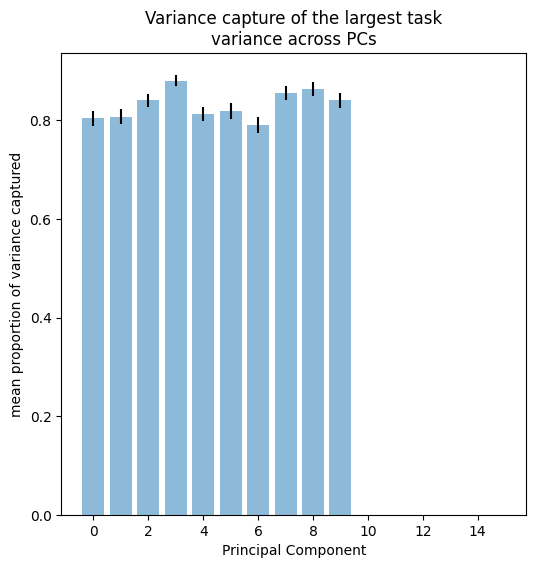

In [66]:
vars = np.concatenate((varAs[:, :, None], varBs[:, :, None]), axis=-1)
variance_capture = vars.max(-1) / vars.sum(-1)
vc_mean = variance_capture.mean(0)
vc_err = variance_capture.std(0) / np.sqrt(len(variance_capture))

_, ax = plt.subplots(figsize=(6, 6))

# plot the variances for task A
ax.bar(range(len(vc_mean)), vc_mean, yerr=vc_err, alpha=0.5)
ax.set_xlabel("Principal Component")
ax.set_ylabel("mean proportion of variance captured")
_ = ax.set_title("Variance capture of the largest task\nvariance across PCs")

It's interesting to me that this is roughly constant across the components! The dominant task for each component seems to always capture ~80% of its variance.

I'd imagine it drops off suddenly due to numerical overflow with the divisions of very small variances so probably not as interesting there.

### Thoughts
- Ok so now I think we can see that at least for this toy model, we can find separate task components
- One issue that remains is that whilst we have task components that are orthogonal, we don't know which ones correspond to which task or whether e.g. three are dedicated to one task and only one to the other
- _Now_ I'm interested to see if we apply this layer by layer whether we can build up a graph of correlated dimensions to achieve clustering/classification of class components:
    1. calculate PCs for all the layers
    1. produce simple correlation/covariance matrices between each principal component in each subsequent layer - I'd hope that since we're only talking about 1-layer differences then we have a chance in not losing the connections between layers
    1. use these to create subgraphs across the whole network, linking the PCs
    1. Apply some kind of covariance thresholding to cluster into separate tasks maybe?
    1. **_Surely_ someone has done this before**